In [7]:
from dap_aria_mapping.getters.docs_with_topics import openalex_with_coocc_topics, patents_with_coocc_topics
from dap_aria_mapping.getters.taxonomies import get_cooccurrence_taxonomy
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})


In [8]:
oa = openalex_with_coocc_topics(level = 1)

In [9]:
patents = patents_with_coocc_topics(level = 1)

In [10]:
def topic_distributions(docs):
    absolute_dist = defaultdict(int)
    for doc, topics in docs.items():
        for topic in set(topics):
            absolute_dist[topic] += 1
    proportional_dist = defaultdict(float)
    for key, val in absolute_dist.items():
        proportional_dist[key] = val/len(docs)
        
    return absolute_dist, proportional_dist

In [11]:
def taxonomy_distribution(taxLevel):
    dist = defaultdict(float)
    for taxid, count in pd.DataFrame(taxLevel.value_counts()).iterrows():
        dist[taxid] = count[0]/len(taxLevel)
    return dist

In [12]:
oa_abs_dist, oa_proportion_dist = topic_distributions(oa)

In [13]:
patent_abs_dist, patent_proportion_dist = topic_distributions(patents)

In [14]:
tax = get_cooccurrence_taxonomy()

### Distribution of Taxonomy at Level 1

This plot shows the percent of entities in the entire corpus allocated to each topic. The distribution is clearly quite skewed, so this needs to be considered when evaluating the proportion of documents on certain topics.

<BarContainer object of 25 artists>

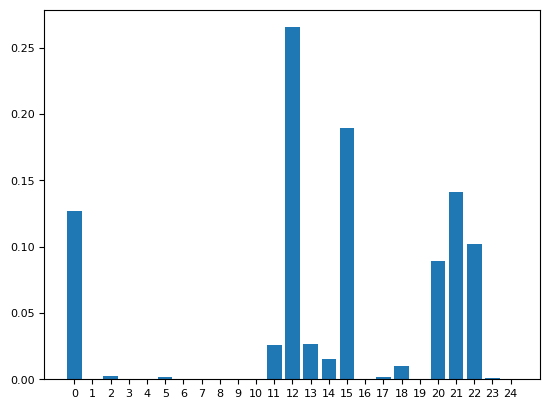

In [15]:
level1tax = tax['Level_1']
tax_dist = taxonomy_distribution(level1tax)
plt.bar([int(key) for key in tax_dist.keys()], tax_dist.values(),tick_label = [int(key) for key in tax_dist.keys()] )

# Proportion of Topics 

## OpenAlex

<BarContainer object of 25 artists>

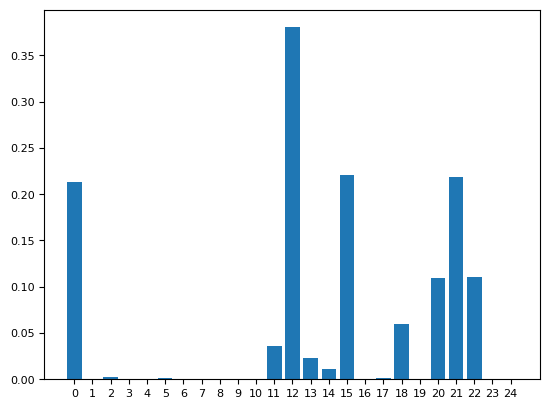

In [16]:
plt.bar([int(key) for key in oa_proportion_dist.keys()], oa_proportion_dist.values(),tick_label = [int(key) for key in oa_proportion_dist.keys()] )

## Patents 

<BarContainer object of 19 artists>

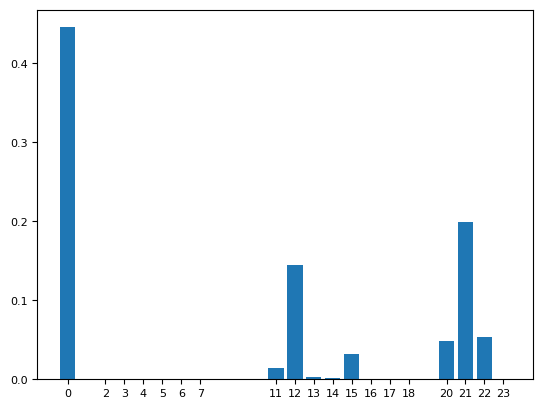

In [17]:
plt.bar([int(key) for key in patent_proportion_dist.keys()], patent_proportion_dist.values(),tick_label = [int(key) for key in patent_proportion_dist.keys()] )

## Highlighted Findings 

Topic 0 appears to be more represented in Patents vs. Publications - Over 40% of documents in Patents are about topic 0, whereas only about 20% of Publications are on Topic 0. A random sample of 50 entities from Topic 0 shows that it is likely about Chemical Engineering. 

In [18]:
print(random.sample(list(tax[tax['Level_1']=='0'].index),50))

['Provincial Highway 3 (Taiwan)', 'Butler–Volmer equation', 'Reversed field pinch', 'UK Clinical Aptitude Test', 'Uranium dioxide', 'Alginic acid', 'Poly(N-isopropylacrylamide)', 'Headstock', 'Physical Review Letters', 'The Purge', 'Electrostriction', 'Alphen aan den Rijn', 'Walter H. Schottky', 'Nacelle', 'Impeller', 'Susceptance', '3rd Marine Artillery Regiment', 'Fabric softener', 'Optical fiber', 'Photon counting', 'Propulsive efficiency', 'Boeing C-17 Globemaster III', 'Sorbitan monolaurate', 'Criticality accident', 'Aromatic sulfonation', 'Diphenylcyclopropenone', 'Butyronitrile', 'N-Butanol', 'Tryptamine', 'Pharr, Texas', 'Capacitive deionization', 'Helmholtz resonance', 'Fluorophore', 'Folding bicycle', 'Dual-phase steel', 'Berreman Township, Jo Daviess County, Illinois', 'Thermal printing', 'Hot particle', 'Supercharger', 'Coulomb barrier', 'Peter Debye', 'Tert-Butyllithium', 'Electromagnetic induction', 'Dithiolane', 'Photoelectrochemical cell', 'Polarization-division multipl

Topic 15 appears to be more represented in Publications vs. Patents - About 20% of documents in Publications are about topic 15, whereas only about 5% of Patents are on Topic 15. A random sample of 50 entities from Topic 15 shows that it is likely related to Sociology.

In [19]:
print(random.sample(list(tax[tax['Level_1']=='15'].index),50))

['Historical archaeology', 'Glostrup', 'Blackpool Victoria Hospital', 'Sprain', 'National electoral calendar 2012', 'Hiberno-English', 'Interprofessional education', 'Niki Sanders', 'Middlesbrough F.C.', 'Potosi', 'John Major', 'Reader-response criticism', 'Alasdair MacIntyre', 'Cochabamba', 'Cupid', 'Rum', 'Institutional ethnography', 'Forge', 'Category mistake', 'Edward Bouverie Pusey', 'Historical dynamics', 'Evidence-based policing', 'Dominican Order', 'Battle of Singapore', 'Communist party', 'Global News', 'Gustave Roussy', 'Urban Realm', '1997 Asian financial crisis', 'Marie Stopes International', 'Marlborough College', 'Gun control', 'Karolinska University Hospital', 'G20', 'John Dewey', 'Self-translation', 'Knoxville Campaign', 'Autopoiesis', 'Hyderabad', 'Network-centric warfare', 'Reading F.C.', 'Urban exploration', 'Net generation', 'LiveJournal', 'Octopussy', 'Palestine Liberation Organization', 'Apologize (OneRepublic song)', 'Organizational identification', 'Odyssey', 'S

# Focus on Composition of Topic 21 - Computer Science / Mathematics

In [20]:
print(random.sample(list(tax[tax['Level_1']=='21'].index),50))

['Price discovery', 'Command and control', 'Filter bank', 'Classifying space', 'NL-complete', 'Grid computing', 'Congruence subgroup', 'Graceful exit', 'Temporal discretization', 'Unit vector', 'Functional data analysis', 'Black hole', 'Combinatorial design', 'Deviance information criterion', 'Data compression', 'Non-Euclidean geometry', 'Polygon mesh', 'Hankel transform', 'Community informatics', 'Creative accounting', 'Stochastic dominance', 'Principal curvature', 'Algebraic structure', 'Data aggregation', 'Bring your own device', 'Baker Botts', 'Hugh Everett III', 'Spectral geometry', 'Associative algebra', 'Deep belief network', 'Hilbert scheme', 'Microsoft Office', 'Belief propagation', 'Cognitive computing', 'Hecke algebra of a locally compact group', 'Portlet', 'Seesaw', 'Hans Zassenhaus', 'Treebank', 'Femtocell', 'RISC-V', 'Payment Card Industry Data Security Standard', 'Codimension', 'Birds in music', 'Free boundary condition', 'FK Rad', 'Convex polytope', 'Coiflet', 'Computat

In [21]:
print(tax.filter(items = ['Computer science'], axis=0))
print(tax.filter(items = ['Artificial intelligence'], axis=0))
print(tax.filter(items = ['Machine learning'], axis=0))

                 Level_1 Level_2   Level_3      Level_4      Level_5
Entity                                                              
Computer science      21   21_25  21_25_27  21_25_27_14  21_25_27_14
                        Level_1 Level_2  Level_3    Level_4    Level_5
Entity                                                                
Artificial intelligence      21   21_52  21_52_2  21_52_2_2  21_52_2_2
                 Level_1 Level_2 Level_3   Level_4   Level_5
Entity                                                      
Machine learning      21    21_7  21_7_5  21_7_5_8  21_7_5_8


## Level 2

In [22]:
oa2 = openalex_with_coocc_topics(level = 2)
patents2 = patents_with_coocc_topics(level = 2)

### OpenAlex 

In [23]:
blah, oa2dist = topic_distributions(oa2)
oa2dist21 = {k: v for k, v in oa2dist.items() if k[:3] == '21_'}

<BarContainer object of 53 artists>

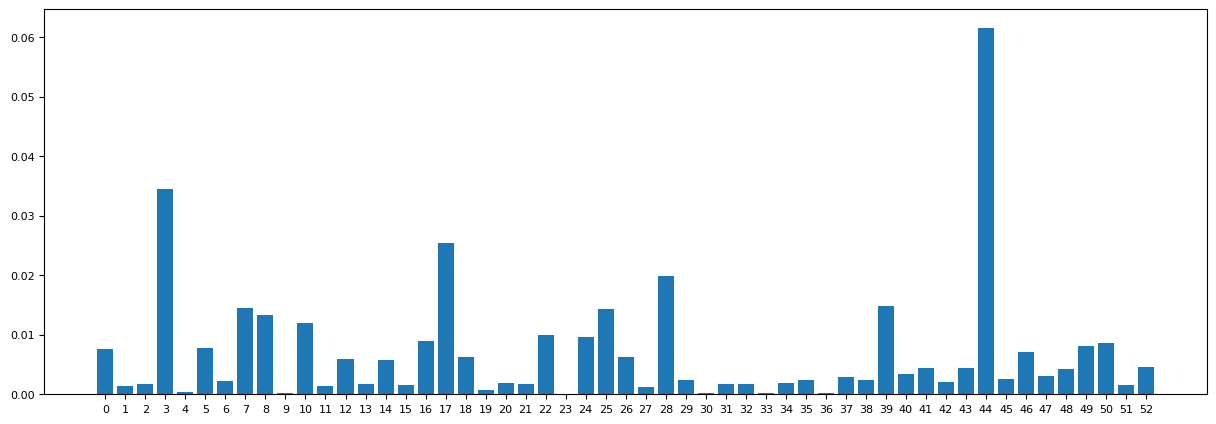

In [24]:
plt.rcParams["figure.figsize"] = (15,5)
plt.bar([int(key.split("_")[1]) for key in oa2dist21.keys()], oa2dist21.values(), tick_label = [int(key.split("_")[1]) for key in oa2dist21.keys()])

### Patents

In [25]:
blah, patents2dist = topic_distributions(patents2)
patents2dist21 = {k: v for k, v in patents2dist.items() if k[:3] == '21_'}

<BarContainer object of 52 artists>

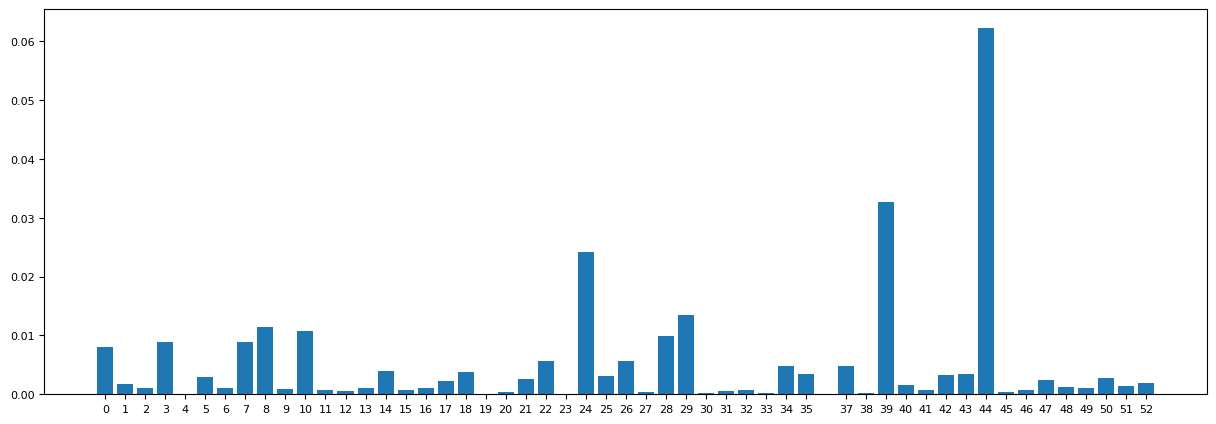

In [26]:
plt.bar([int(key.split("_")[1]) for key in patents2dist21.keys()], patents2dist21.values(), tick_label = [int(key.split("_")[1]) for key in patents2dist21.keys()])

## Interesting Findings 

At the higest level, both Patents and Publications appear to be about Topic 21 approx 20% of the time. Topic 21 appears to contain content related to Computer Science/Mathematics. What is interesting is the breakdown of that topic within Patents and Publictations.

Sub-topic 24 is the 3rd most represented topic within 21 in patents, with about 2.5% of all patents being about that sub-topic. However <1% of all publications are on that subtopic. A random sample of the entities within that subtopic shows that it appears to be about cybersecurity.

Sub-topic 39 shows a similar pattern. It is in over 3% of all patents, but about 1% of publications. Sub-topic 39 appears to be about scaled computing architectures.

In [27]:
print(random.sample(list(tax[tax['Level_2']=='21_24'].index),50))

['Trade secret', 'Single sign-on', 'Sybil attack', 'Client–server model', 'Replay attack', 'Bootle', 'Advanced Encryption Standard', 'Competition Bureau (Canada)', 'WebRTC', 'Merger guidelines', 'Group signature', 'GSM-R', 'Cryptocurrency', 'BIND', 'Block chain', 'ID-based encryption', 'Identity management system', 'Self-similarity', 'Mobile computing', 'Affinity analysis', 'Algebra', 'Breakcore', 'Relay attack', 'Direct Anonymous Attestation', 'Key encapsulation', 'Black-box testing', 'Hybrid cryptosystem', 'Challenge–response authentication', 'Infrared Data Association', 'Ring learning with errors', 'Bargaining', 'National Institute of Standards and Technology', 'Personal firewall', 'Pseudorandom function family', 'SHA-2', 'Integer factorization', 'Bilinear map', 'Random permutation', 'Federal Trade Commission', 'Oblivious transfer', 'Quantum computing', 'Datagram Transport Layer Security', 'Signal Protocol', 'Homomorphic encryption', 'Eurocrypt', 'Bit array', 'Structural Health Moni

In [37]:
print(random.sample(list(tax[tax['Level_2']=='21_39'].index),50))

['Equal-cost multi-path routing', 'Network processor', 'Defensive back', 'ARM big.LITTLE', 'File system', 'Petascale computing', 'Dependence analysis', 'Design choice', 'Memory safety', 'LINPACK', 'UltraHLE', 'Dynamic programming language', 'Computational aeroacoustics', 'QEMU', 'Intel MPX', 'Stencil code', 'Program counter', 'Test oracle', 'Scheduling (computing)', 'Thread safety', 'Locality of reference', 'Optimistic concurrency control', 'Instruction set', 'Skylake (microarchitecture)', 'Query optimization', 'Floating-point unit', 'Software transactional memory', 'Synchronous dynamic random-access memory', 'Spherical coordinate system', 'Library (computing)', 'Multi-agent system', 'Multiprocessing', 'Stratix', 'Loop dependence analysis', 'Altera Quartus', 'Biological computation', 'Eventual consistency', 'Sequence alignment', 'Compare-and-swap', 'Kernel-based Virtual Machine', 'VLSI Technology', 'Cholesky decomposition', 'Attack surface', 'Exponential integrate-and-fire', 'Bluespec'

On the other hand, sub-topic 17 is much more represented in publications (nearly 3% of all publications), but much less in patents (<1% of all patents). Sub-topic 17 appears to be about Physics.

Similarly, sub-topic 3 is much more represented in publications (>3% of all pubs) but only about 1% of patents. Sub-topic 3 appears to be about finance/economics.

In [29]:
print(random.sample(list(tax[tax['Level_2']=='21_17'].index),50))

['De Sitter space', 'Axion', 'Sphaleron', 'Modular invariance', 'Heisenberg picture', 'Optical theorem', 'Topological quantum field theory', 'Holonomy', 'Gauge fixing', 'Lema', 'Jaynes–Cummings model', 'Worldsheet', 'Principal bundle', 'Octant (instrument)', 'Spin network', 'Hadronization', 'Mackay railway station', 'CP violation', 'CLAS detector', 'psi meson', 'Fundamental interaction', 'B-factory', 'Loop quantum gravity', 'James Clerk Maxwell', 'Einstein tensor', 'Tevatron', 'KMVP-FM', 'Weak isospin', 'Nikolay Bogolyubov', 'Rotating wave approximation', 'M2-brane', 'Majorana equation', 'MINOS', 'Hendrik Lorentz', 'Muon', 'Fisher information', 'Conformal supergravity', 'Statistical physics', 'NuMI', 'Sterile neutrino', 'Spectral color', 'Peter Higgs', 'Back-reaction', 'Kronecker delta', 'Kerr metric', 'Pattern formation', 'C-symmetry', 'Color charge', 'Euclidean space', 'Etal']


In [30]:
print(random.sample(list(tax[tax['Level_2']=='21_3'].index),50))

['National Bureau of Economic Research', 'Statistical process control', 'Quasi-likelihood', 'Asset-backed security', 'Taobao', 'Exponential discounting', 'Cash-in-advance constraint', 'Exchange (organized market)', 'Monetary policy', 'Initial public offering', 'Conditional expectation', 'Russell 2000 Index', 'Balanced-growth equilibrium', 'Federal Open Market Committee', 'Future Profits', 'Intertemporal choice', 'Fixed effects model', 'Market manipulation', 'Carsharing', 'Monetary Policy Committee', 'Bootstrap model', 'Total set', 'Control variates', 'Acid Rain Program', 'Tax noncompliance', 'Credit derivative', 'Core inflation', 'Giffen good', 'Frequentist inference', 'Dependent and independent variables', 'Stay Positive (album)', 'Tick size', 'Headline inflation', 'Double-loop learning', 'Valuation (algebra)', 'Leybourne', 'Vine copula', 'Super-spreader', 'Commodity market', 'Credit bureau', 'EViews', 'Taxation in Japan', 'Accounts receivable', 'Tracking error', 'World oil market chr

## Level 3 

Subtopic 44 is the most prevalent subtopic within 21 for both Publications and Patents, which generally appears to be about networking, but contains other algorithmic terms as well.

In [67]:
print(random.sample(list(tax[tax['Level_2']=='21_44'].index),50))

['Cross-layer optimization', 'Molecular communication', 'Ethernet', 'Signal processing', 'OPNET', 'Service Access Point', 'Connected car', 'Optical communication', 'Repetition code', 'Software-defined radio', 'Adaptive coding', 'Base station', 'Spatial multiplexing', 'End-to-end delay', 'Telnet', 'Mesh networking', 'Viterbi algorithm', 'Convex optimization', 'Small cell', 'Network interface device', 'Location identifier', 'IEEE 802.16', 'Routing table', 'Network planning and design', 'Finite impulse response', 'Time to live', 'Fully qualified domain name', 'Value-added service', 'Bandwidth management', 'GERAN', 'Spectral density', 'Speech synthesis', 'Probabilistic neural network', 'Radio propagation', 'Operations support system', 'IPv4', 'Defragmentation', 'Dynamic Adaptive Streaming over HTTP', 'IEEE 802.11', 'Edge computing', 'Picocell', 'Mobile edge computing', 'Compressed sensing', 'Diversity scheme', 'Error detection and correction', 'Superframe', 'Adaptive switching', 'Synchrono

In [39]:
oa3 = openalex_with_coocc_topics(level = 3)
patents3 = patents_with_coocc_topics(level = 3)

### OpenAlex 

In [43]:
blah, oa3dist = topic_distributions(oa3)
oa3dist21_44 = {k: v for k, v in oa3dist.items() if k[:5] == '21_44'}

<BarContainer object of 45 artists>

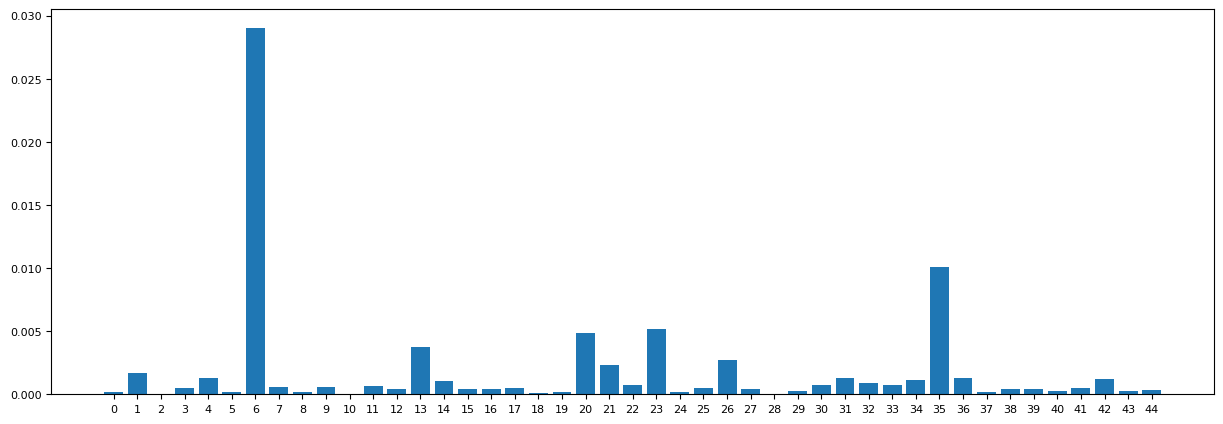

In [47]:
plt.rcParams["figure.figsize"] = (15,5)
plt.bar([int(key.split("_")[2]) for key in oa3dist21_44.keys()], oa3dist21_44.values(), tick_label = [int(key.split("_")[2]) for key in oa3dist21_44.keys()])

### Patents 

In [48]:
blah, patents3dist = topic_distributions(patents3)
patents3dist21_44 = {k: v for k, v in patents3dist.items() if k[:5] == '21_44'}

<BarContainer object of 45 artists>

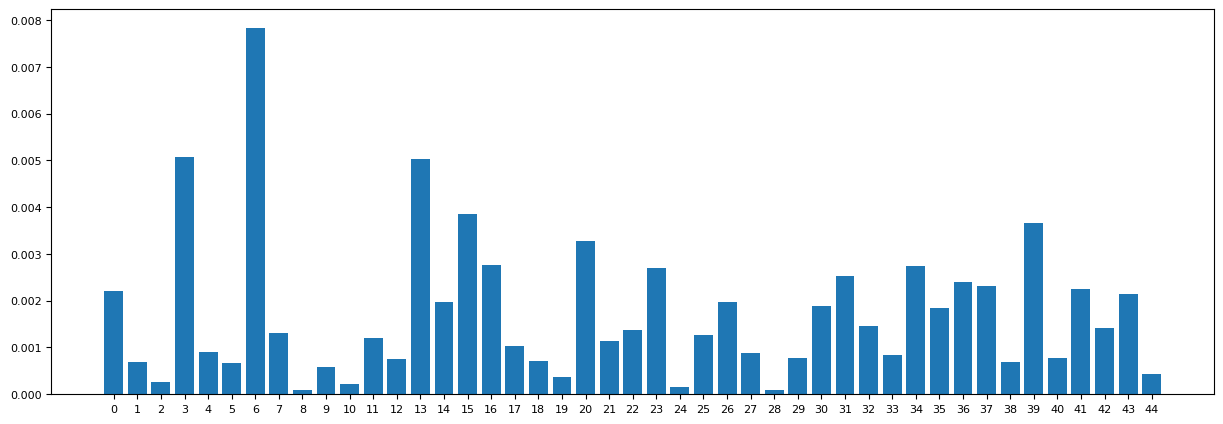

In [49]:
plt.bar([int(key.split("_")[2]) for key in patents3dist21_44.keys()], patents3dist21_44.values(), tick_label = [int(key.split("_")[2]) for key in patents3dist21_44.keys()])

### Interesting Findings 

The distribution of sub-sub-topics within sub-topic 44 is much more skewed for publications. Publications within this sub-stopic, are predominantly about sub-sub topic 6, which is about algorithmic optimisation. 

In [65]:
print(list(tax[tax['Level_3']=='21_44_6'].index))

['Unmanned aerial vehicle', 'Multiple edges', 'Guangzhou Bus Rapid Transit', 'MSISDN', 'Fractional programming', 'Mobile edge computing', 'Supply chain optimization', 'Proximal gradient methods for learning', 'Hadamard matrix', 'Extremely high frequency', 'Convex optimization', 'Coordinate descent', 'Nonnegative matrix', 'Mathematical optimization', 'Demand load', 'Stochastic optimization', 'Ky Fan', 'Duality (optimization)', 'Edge computing', 'Segment routing', 'Value-added service', 'Lyapunov optimization', 'Microsoft Edge', 'Content delivery network', 'Algorithm']


There are a significant number of patents in may other sub-sub topics within sub-topic 44, such as 3 and 39 which both appear to be about telecommunications. 

In [71]:
print(list(tax[tax['Level_3']=='21_44_3'].index))
print(list(tax[tax['Level_3']=='21_44_39'].index))

['E-UTRA', 'Media gateway', 'Packet radio', 'Mobile radio', 'Radio access network', 'UMTS Terrestrial Radio Access Network', 'Information system', 'Network switching subsystem', 'Source Radio', 'Mobile phone', 'System Architecture Evolution', 'Legacy system', 'Circuit switching', 'Voice call continuity', 'New York Call', 'GSM', 'General Packet Radio Service', 'GPRS core network', 'GERAN', 'High Speed Packet Access', 'UMTS (telecommunication)', 'Access stratum', 'Radio Network Controller', 'Telecommunications network']
['Multimedia Broadcast Multicast Service', 'Single-frequency network', 'Push-to-talk', '3GPP', 'LTE (telecommunication)', 'Communications system']
